In [972]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
%matplotlib inline

In [973]:
def reshapes(m,l,dim):
    m = m.reshape(dim)
    l = l.reshape(dim)
    return m,l

In [974]:
# OPENING THE PHOTO AND CROPPING AND RESIZING
# Name bolt1.jpg
def open_resize_image(str):
    image = Image.open(str)
    plt.imshow(image)
    new_image = image.resize((64,128))
    return new_image

In [975]:
def normalize(image):
    image = np.float32(image) / 255.0
    return image
        

In [976]:
def gradients(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
#     m = np.sqrt(gx**2 + gy**2)
#     d = np.arctan2(gy , gx)
    m, d = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    d = np.around(d)
    return m , d

In [977]:
def max_md(m , d):
    a = m.argmax(axis=2)
    l = np.zeros((128,64,1))
    for i in range(128):
        for j in range(64):
            l[i][j] = (d[i][j][a[i][j]])
            if l[i][j] > 180:
                l[i][j] = 360 - l[i][j]
            
    m = m.max(axis=2,keepdims=True)
    return m , l

In [978]:
def get_bin(m ,d ,stride = 8):
    blockd = []
    blockm = []
    for i in range(0,128,stride):
        for j in range(0,64,stride):
            blockd.append(d[i:i+stride,j:j+stride])
            blockm.append(m[i:i+stride,j:j+stride])
    return blockm , blockd

In [979]:
def get_ratio(lim1,lim2,val):
    return (val - lim1) / (lim2 - lim1)

In [980]:
def h(m , d):
    histogram = {}
    index = [0,20,40,60,80,100,120,140,160]
    for i in index:
        histogram[i] = histogram.get(i,0)
    for i in range(8):
        for j in range(8):
            for k in range(9):
                if index[k] - d[i][j] > 0:
                    ratio = get_ratio(index[k-1],index[k],d[i][j])
                    histogram[index[k-1]] += (m[i][j] * ratio)
                    histogram[index[k]] += m[i][j] * (1 - ratio)
                    break
    return histogram

In [981]:
def generating_histograms(blockm , blockd ):
    hists = []
    for i in range(len(blockm)):
        hists.append(h(blockm[i],blockd[i]))
    return hists
        

In [982]:
def sixteen_sixteen(histograms, stride = 1):
    feature_vectors = []
    for i in range(16-stride):
        for j in range(8-stride):
            feature_vectors.append(list(histograms[i][j].values()) + list(histograms[i+1][j].values()) + 
            list(histograms[i][j+1].values()) + list(histograms[i+1][j+1].values()))
    return feature_vectors

In [983]:
def flatten(fv):
    fv = np.array(fv).flatten()
    return fv

In [995]:
def normalize2(fv):
    for i in range(len(fv)):
        l2 = np.linalg.norm(fv[i])
        if l2 == 0:
            continue
        fv[i] = fv[i] / l2
    return fv

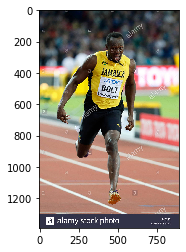

In [996]:
# TESTING BLOCK
image = open_resize_image("bolt1.jpg")
image = normalize(image)
m , d = gradients(image)
m , l = max_md(m,d)
m , l = reshapes(m,l,(128,64))
blockm , blockd = get_bin(m,l)
histograms = generating_histograms(blockm,blockd)
histograms = np.array(histograms).reshape((16,8))
fv = sixteen_sixteen(histograms,stride=1)
fv = normalize2(fv)
fv = flatten(fv)

In [997]:
fv = fv.tolist()

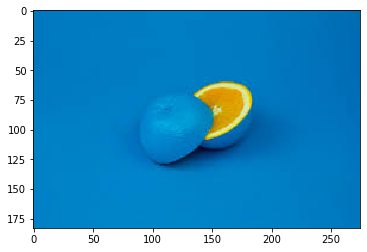

In [1112]:
image2 = open_resize_image("test1.jpg")
image2 = normalize(image2)
m2 , d2 = gradients(image2)
m2 , l2 = max_md(m2,d2)
m2 , l2 = reshapes(m2,l2,(128,64))
blockm2 , blockd2 = get_bin(m2,l2)
histograms2 = generating_histograms(blockm2,blockd2)
histograms2 = np.array(histograms2).reshape((16,8))
fv2 = sixteen_sixteen(histograms2,stride=1)
fv2 = normalize2(fv2)
fv2 = flatten(fv2)

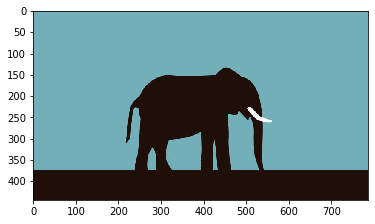

In [998]:
image1 = open_resize_image("nothuman.jpg")
image1 = normalize(image1)
m1 , d1 = gradients(image1)
m1 , l1 = max_md(m1,d1)
m1 , l1 = reshapes(m1,l1,(128,64))
blockm1 , blockd1 = get_bin(m1,l1)
histograms1 = generating_histograms(blockm1,blockd1)
histograms1 = np.array(histograms1).reshape((16,8))
fv1 = sixteen_sixteen(histograms1,stride=1)
fv1 = normalize2(fv1)
fv1 = flatten(fv1)

In [1111]:
X = [fv,fv1]
Y = [1,0]

In [1110]:
from sklearn.svm import SVC
import pandas as pd

In [1106]:
clf = SVC(kernel='linear',gamma=0.2)
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1116]:
yp = clf.predict([fv2])
print(yp)

[0]
